# Building Deep Learning Models with PyTorch

**Objective**: By the end of this workshop, participants will have a basic understanding of how to build a deep learning model from scratch using PyTorch and will be able to apply this knowledge to their own projects.

<a target="_blank" href="https://colab.research.google.com/github/Nikhil0504/deep-learning/blob/main/buliding_cnns.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

> NOTE: If you are using Google Colab, make sure to use this procedure to equip the GPU.
**Runtime -> Change runtime type -> Hardware Accelerator (T4 GPU)**

## Introduction to Deep Learning
Deep learning is a subfield of machine learning that involves the use of neural networks to analyze and interpret data. Neural networks are composed of multiple layers of interconnected nodes or "neurons," which process and transform the input data.

![image.png](https://www.ait.de/wp-content/uploads/2022/01/Vergleich-Machine-Learning-Deep-Learning-2048x1536.png)

## Key Components of Deep Learning
1. **Artifical Neurons (Nodes)**: These are the basic building blocks of a neural network. Each node receives one or more inputs, performs a computation on those inputs, and then sends the output to other nodes.
2. **Connections (Edges)**: These are the links between nodes, which allow them to exchange information.
3. **Activation Functions**: These are the mathematical functions that are applied to the output of each node to introduce non-linearity into the model.
4. **Layers**: A neural network is composed of multiple layers, each containing a set of nodes. The first layer is the input layer, followed by one or more hidden layers, and finally the output layer.

## What is PyTorch?
PyTorch is an open-source machine learning library developed by Facebook's AI Research Lab (FAIR). It provides a dynamic computation graph and is particularly well-suited for rapid prototyping and research.

## Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) have revolutionized the field of computer vision. Unlike traditional neural networks, CNNs are specifically designed to process data with a grid-like topology, such as images.

In this workshop, we'll build a CNN from scratch to understand its fundamental components, and then leverage the power of transfer learning with pre-trained models to see how modern deep learning approaches work in practice.

In [1]:
# Part 1: Setting up environment

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Dataset - Fashion MNIST
Fashion MNIST was created by Zalando Research as a drop-in replacement for the original MNIST dataset. While MNIST contains handwritten digits (0-9), Fashion MNIST contains 70,000 grayscale images of clothing items across 10 categories.

In this section, we will explore the dataset in detail, including how to load it, visualize some examples, and preprocess the images for training.

Dataset Details:
- Images: 28×28 pixel grayscale
- Classes: 10 categories of clothing items
- Training set: 60,000 images
- Test set: 10,000 images
- Format: Each image is normalized and centered

The 10 categories are:
| Class ID | Class Name       |
|----------|------------------|
| 0        | T-shirt/top      |
| 1        | Trouser          |
| 2        | Pullover         |
| 3        | Dress            |
| 4        | Coat             |
| 5        | Sandal           |
| 6        | Shirt            |
| 7        | Sneaker          |
| 8        | Bag              |
| 9        | Ankle boot       |

In [11]:
# Part 2: Data Preparation

# Define transformations for the training and validation sets
# The transform makes sure that the images are in the right format for the model

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Create data loaders for training and testing
# Batch size refers to the number of samples processed before the model is updated
batch_size = 64 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# TODO: Create DataLoader for test dataset (same as train_loader but with test_dataset)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Define class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [16]:
# Visualize some examples from the dataset
def visualize_dataset(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Create a grid of images
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

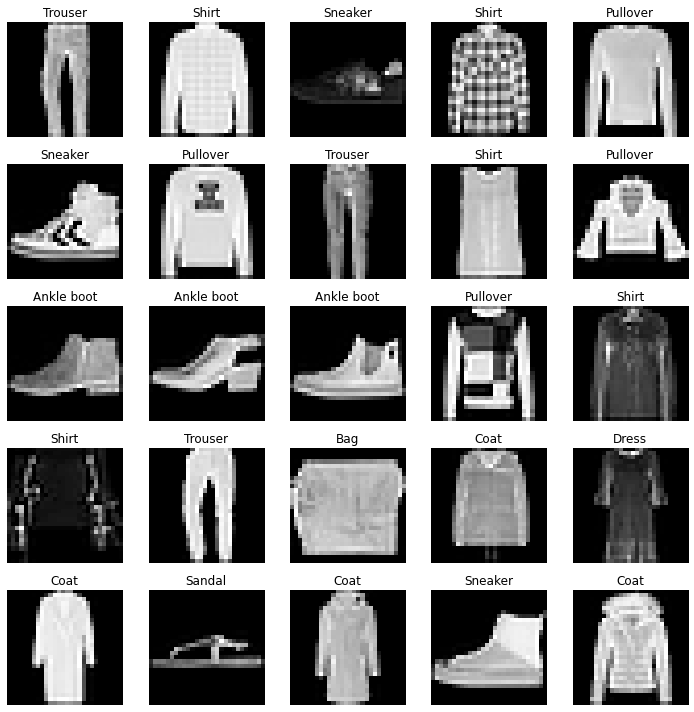

In [17]:
# Run this code to visualize the dataset
visualize_dataset(train_loader)

# Fundementals of CNNs and Pytorch

## Understanding CNNs: The Building Blocks

Before we build our model, let's understand the key components of a CNN:

### 1. Convolutional Layers

Convolutional layers are the core building blocks of CNNs. They work by:
- Sliding a small filter (kernel) across the input image
- Performing element-wise multiplication at each position
- Summing the results to produce a feature map

#### Key Parameters:
- **in_channels**: Number of input channels (1 for grayscale, 3 for RGB)
- **out_channels**: Number of filters/kernels to learn
- **kernel_size**: Size of the convolutional filter (e.g., 3×3, 5×5)
- **stride**: Step size when sliding the filter
- **padding**: Adding zeros around the input to preserve spatial dimensions

### 2. Activation Functions (ReLU)

After convolution, we apply a non-linear activation function:
- Introduces non-linearity to the model
- Enables learning of complex patterns
- ReLU (Rectified Linear Unit) is most common: f(x) = max(0, x)

### 3. Pooling Layers

Pooling reduces the spatial dimensions of the feature maps:
- **Max Pooling**: Takes maximum value in each window
- **Average Pooling**: Takes average value in each window
- Reduces computational complexity
- Provides translation invariance

### 4. Fully Connected Layers

After extracting features with convolutional layers:
- Flatten the feature maps into a 1D vector
- Connect to fully connected (dense) layers
- Final layer outputs class probabilities


In [ ]:
def visualize_convolution_and_pooling():
    # Get a single image
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    single_image = images[0].unsqueeze(0)  # Add batch dimension
    
    # Define a simple filter for demonstration (edge detection)
    edge_filter = torch.tensor([[-1, -1, -1],
                                [-1,  8, -1],
                                [-1, -1, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Apply convolution manually
    conv_layer = nn.Conv2d(1, 1, kernel_size=3, bias=False)
    conv_layer.weight.data = edge_filter
    
    # Get the feature map
    with torch.no_grad():
        feature_map = conv_layer(single_image)
    
    # Apply ReLU
    relu_feature_map = F.relu(feature_map)
    
    # Apply max pooling
    pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
    pooled_feature_map = pool_layer(relu_feature_map)
    
    # Plot original image, feature map, and pooled feature map
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(single_image.squeeze().numpy(), cmap='gray')
    plt.title(f'Original: {class_names[labels[0]]}')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(feature_map.squeeze().numpy(), cmap='viridis')
    plt.title('After Convolution')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(relu_feature_map.squeeze().numpy(), cmap='viridis')
    plt.title('After ReLU')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(pooled_feature_map.squeeze().numpy(), cmap='viridis')
    plt.title('After Max Pooling')
    plt.axis('off')
    
    plt.suptitle('Visualizing Convolution, ReLU and Pooling Operations', fontsize=16)
    plt.tight_layout()
    plt.show()

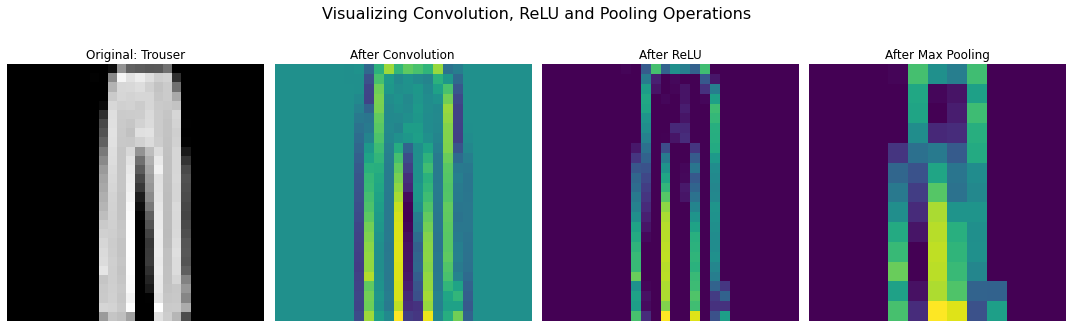

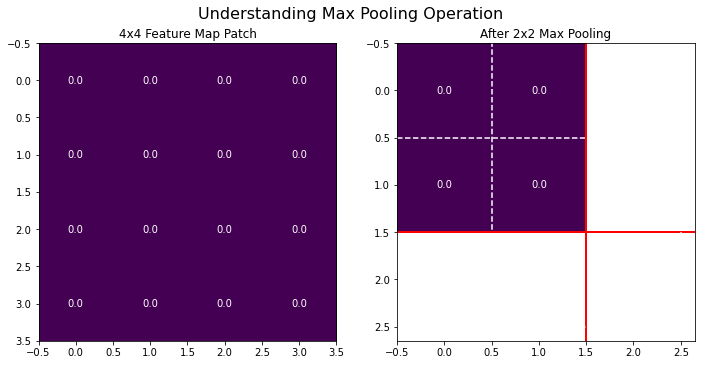

In [19]:
# Visualize how convolution and pooling work
visualize_convolution_and_pooling()

# Implementing a CNN in PyTorch

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        # Input: 1x28x28, Output: 32x26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # After ReLU: 32x26x26
        
        # First max pooling layer
        # Input: 32x26x26, Output: 32x13x13
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # TODO: Second convolutional layer
        # Input: 32x13x13, Output: 64x11x11
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # After ReLU: 64x11x11
        
        # TODO: Second max pooling layer
        # Input: 64x11x11, Output: 64x5x5
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # TODO: Fully connected layers
        # Input: 64*5*5 = 1600
        self.fc1 = nn.Linear(64 * 5 * 5, 128)

        # TODO: Output: 128 (hidden layer)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion MNIST
        
    def forward(self, x):
        # Apply first conv layer, then ReLU activation, then pooling
        x = self.pool1(F.relu(self.conv1(x)))
        
        # TODO: Apply second conv layer, then ReLU activation, then pooling
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 5 * 5)
        
        # TODO: Apply first fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        
        # TODO: Apply final fully connected layer 
        # (no activation - will be applied in loss)
        x = self.fc2(x)
        
        return x

In [21]:
# Create an instance of our model and move it to the device
model_scratch = SimpleCNN().to(device)
print(model_scratch)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Part 4: Training the Model

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Set model to training mode
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Iterate over batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluate on test set
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print statistics
        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, '
              f'Time: {elapsed_time:.2f}s')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

def evaluate_model(model, data_loader, criterion):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # No gradient calculation needed for evaluation
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate overall statistics
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100.0 * correct / total
    
    return loss, accuracy

In [23]:
# Define loss function and optimizer
# CrossEntropyLoss is suitable for multi-class classification
criterion = nn.CrossEntropyLoss() 

optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

In [24]:
num_epochs = 5

# TODO: fill the required parameters and call the train_model function
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model_scratch, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 1/5, Train Loss: 0.4793, Train Acc: 82.63%, Test Loss: 0.3676, Test Acc: 86.50%, Time: 46.56s
Epoch 2/5, Train Loss: 0.3115, Train Acc: 88.67%, Test Loss: 0.3118, Test Acc: 88.67%, Time: 83.82s
Epoch 3/5, Train Loss: 0.2616, Train Acc: 90.32%, Test Loss: 0.2861, Test Acc: 89.72%, Time: 175.04s
Epoch 4/5, Train Loss: 0.2324, Train Acc: 91.43%, Test Loss: 0.2658, Test Acc: 90.54%, Time: 91.44s
Epoch 5/5, Train Loss: 0.2080, Train Acc: 92.09%, Test Loss: 0.2867, Test Acc: 89.48%, Time: 62.25s


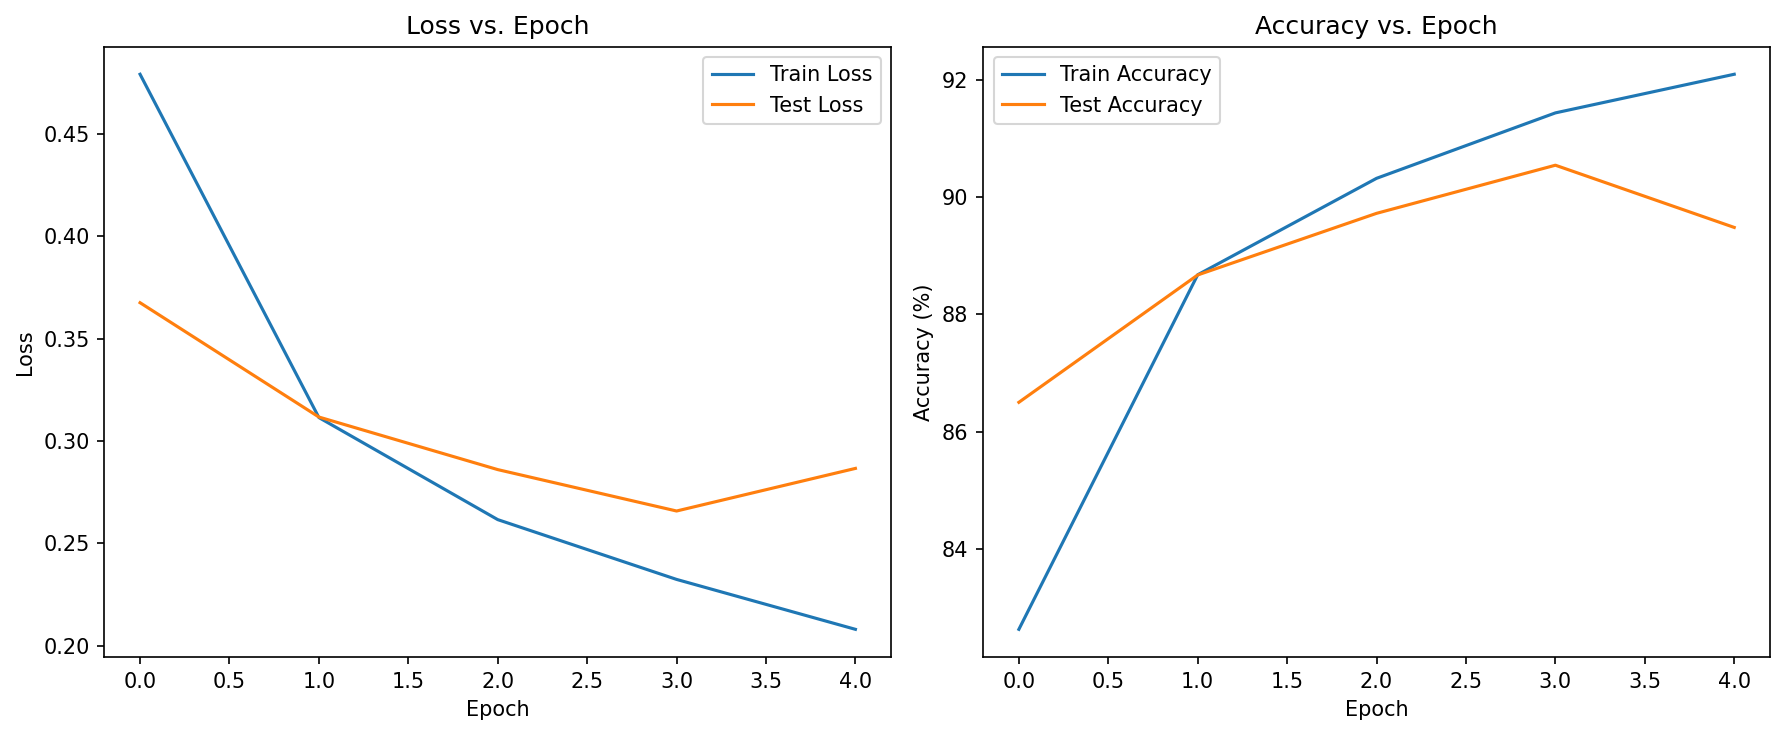

In [30]:
# Visualize the training progress
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(test_losses, label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss vs. Epoch')

ax[1].plot(train_accuracies, label='Train Accuracy')
ax[1].plot(test_accuracies, label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].set_title('Accuracy vs. Epoch')

plt.tight_layout()
plt.show()

In [31]:
# Part 5: Visualise the CNN's results

def visualize_predictions(model, loader):
    # Set model to evaluation mode
    model.eval()
    
    # Get a batch of test data
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Move to the same device as the model
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Move tensors back to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    # Create a grid of images with predictions
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}', 
                 color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

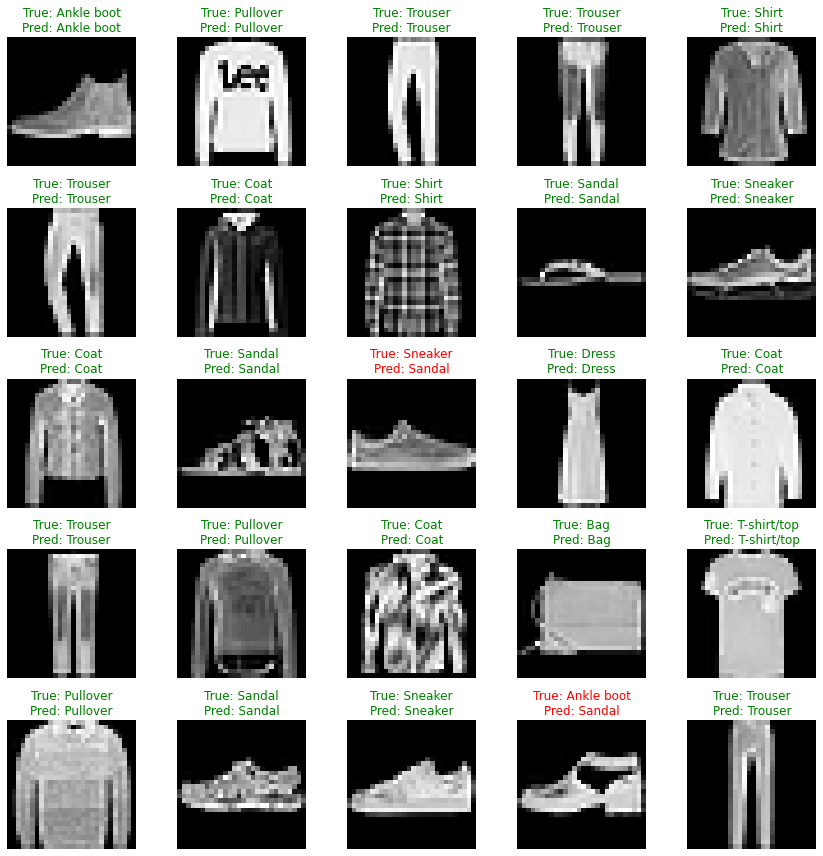

In [32]:
# Visualize some predictions from our scratch model
visualize_predictions(model_scratch, test_loader)

## Introduction to Transfer Learning

Transfer learning is a powerful technique in deep learning where a model developed for one task is reused as the starting point for a model on a second task. It's particularly effective when:

1. You have limited training data
2. The pre-trained model was trained on a related domain
3. You want to reduce training time and computational resources

### Why Transfer Learning Works:

- Lower-level features (edges, textures, patterns) are often universal
- Pre-trained models have already learned these features from millions of images
- We only need to fine-tune the model to our specific task

### The Process:

1. **Take a pre-trained model** (like ResNet, VGG, etc.) trained on a large dataset (e.g., ImageNet)
2. **Remove the final classification layer** (specific to the original task)
3. **Add a new classification layer** for our number of classes
4. **Freeze early layers** to preserve learned features
5. **Train only the new layers** (or fine-tune some of the later layers)

### Advantages:

- **Faster convergence**: The model already understands basic visual features
- **Better performance**: Especially with limited data
- **Less computational resources**: Most of the network is already trained

Let's implement transfer learning using ResNet-18:

In [ ]:
# We need to adapt our approach for pre-trained models since Fashion MNIST is grayscale
# and most pre-trained models expect 3-channel RGB images

# Define a new transformation for using pre-trained models
transform_pretrained = transforms.Compose([
    # ImageNet stats see https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights
    transforms.Grayscale(3),  # Convert grayscale to 3 channels
    transforms.Resize(224),  # Resize to match pre-trained model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# TODO: Load the Fashion MNIST dataset with the new transformations 
train_dataset_pretrained = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_pretrained)
test_dataset_pretrained = datasets.FashionMNIST('./data', train=False, download=True, transform=transform_pretrained)

In [34]:
# TODO: Create data loaders
# Smaller batch size due to larger images
batch_size_pretrained = 32  
train_loader_pretrained = DataLoader(train_dataset_pretrained, batch_size=batch_size_pretrained, shuffle=True)
test_loader_pretrained = DataLoader(test_dataset_pretrained, batch_size=batch_size_pretrained, shuffle=False)

In [35]:
# Load a pre-trained ResNet-18 model
pretrained_model = models.resnet18(pretrained=True)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
pretrained_model
# as we can see, the model expects 3-channel input 
# and has 1000 output classes (for ImageNet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# Modify the model for our task
num_ftrs = pretrained_model.fc.in_features  # Get the number of input features for the last layer
pretrained_model.fc = nn.Linear(num_ftrs, 10)  # Change output to 10 classes for Fashion MNIST

In [39]:
# Move the model to the device
pretrained_model = pretrained_model.to(device)

In [40]:
# Freeze most of the network, only train the final layers
for param in list(pretrained_model.parameters())[:-2]:
    param.requires_grad = False

In [41]:
# Define loss function and optimizer for the pre-trained model
criterion_pretrained = nn.CrossEntropyLoss()
optimizer_pretrained = optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=0.001)

In [42]:
# TODO: Train the pre-trained model
num_epochs_pretrained = 3

train_losses_pretrained, train_accuracies_pretrained, test_losses_pretrained, test_accuracies_pretrained = train_model(
    pretrained_model, train_loader_pretrained, test_loader_pretrained, criterion_pretrained, optimizer_pretrained, num_epochs_pretrained)

KeyboardInterrupt: 

In [ ]:
# Visualize the training progress for the pre-trained model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_pretrained, label='Train Loss')
plt.plot(test_losses_pretrained, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pre-trained Model: Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_pretrained, label='Train Accuracy')
plt.plot(test_accuracies_pretrained, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Pre-trained Model: Accuracy vs. Epoch')

plt.tight_layout()
plt.show()

In [ ]:
def compare_models():
    print("\nModel Comparison:")
    print("-" * 50)
    print(f"Scratch CNN Final Test Accuracy: {test_accuracies[-1]:.2f}%")
    print(f"Pre-trained Model Final Test Accuracy: {test_accuracies_pretrained[-1]:.2f}%")
    
    improvement = test_accuracies_pretrained[-1] - test_accuracies[-1]
    print(f"\nImprovement with Transfer Learning: {improvement:.2f}%")
    
    # Visualize the comparison
    models_names = ['Scratch CNN', 'Pre-trained ResNet-18']
    final_accuracies = [test_accuracies[-1], test_accuracies_pretrained[-1]]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models_names, final_accuracies, color=['skyblue', 'orange'])
    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy Comparison')
    plt.ylim(0, 100)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [ ]:
compare_models()